##### AUTHOR: Aya Tarist

### Project Scope:

- The main goal of this project is to develop a machine learning method to forecast the ranking of Formula 1 Grand Prix races. By analyzing a mix of current and historical data, we strive to deliver precise predictions to support fans, team managers, and bettors in their decision-making processes. Our approach involves thorough data analysis to pinpoint the key factors that determine race outcomes and to project a set of likely final rankings.

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, classification_report, precision_score,
                             f1_score, recall_score, accuracy_score, roc_curve, auc,
                             precision_recall_curve, mean_squared_error, balanced_accuracy_score)
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import pickle

# Set display and style options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
np.set_printoptions(precision=4)

# Suppress specific category of warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/var/folders/57/0prtk0lx6472gt0k44smsqcc0000gn/T/ipykernel_23379/2747344324.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#reading the preprocessed data - (output of phase 1)
data = pd.read_csv('~/ANOP330/FinalProject/cleaned_data.csv')

In [3]:
data.head()

,raceId,season,raceNumber,prixName,raceDate,driverId,constructorId,driverStartGridPos,driverFinalGridPos,driverFinalRank,driverRacePoints,driverLapCount,driverFatestLapNumber,driverFastestLapTime,driverFastestLapSpeed,constructorRacePoints,driverNumber,driverDateOfBirth,driverNationality,constructorName,constructorNationality,constructorChampionshipStandingPoints,constructorChampionshipStandingPosition,constructorChampionshipStandingWins,driverChampionshipStandingPoints,driverChampionshipStandingPosition,driverChampionshipStandingWins,circuitName,circuitLocation,circuitCountry,driverRaceResultStatus,driverName,driverAge,driverDnf,constructorDnf
0,1,2009,1,Australian Grand Prix,2009-03-29,18,23,1,1.0,1,10.0,58.0,17.0,1:28.020,216.891,18.0,22.0,1980-01-19,British,Mercedes,British,18.0,1.0,1.0,10.0,1.0,1.0,Albert Park Grand Prix Circuit,Melbourne,Australia,Finished,Jenson Button,43.0,0,1
1,1,2009,1,Australian Grand Prix,2009-03-29,22,23,2,2.0,2,8.0,58.0,43.0,1:29.066,214.344,18.0,0.0,1972-05-23,Brazilian,Mercedes,British,18.0,1.0,1.0,8.0,2.0,0.0,Albert Park Grand Prix Circuit,Melbourne,Australia,Finished,Rubens Barrichello,51.0,0,1
2,1,2009,1,Australian Grand Prix,2009-03-29,15,7,20,3.0,3,6.0,58.0,50.0,1:28.916,214.706,11.0,0.0,1974-07-13,Italian,Toyota,Japanese,11.0,2.0,0.0,6.0,3.0,0.0,Albert Park Grand Prix Circuit,Melbourne,Australia,Finished,Jarno Trulli,49.0,0,1
3,1,2009,1,Australian Grand Prix,2009-03-29,10,7,19,4.0,4,5.0,58.0,53.0,1:28.416,215.920,11.0,0.0,1982-03-18,German,Toyota,Japanese,11.0,2.0,0.0,5.0,4.0,0.0,Albert Park Grand Prix Circuit,Melbourne,Australia,Finished,Timo Glock,41.0,0,1
4,1,2009,1,Australian Grand Prix,2009-03-29,4,4,10,5.0,5,4.0,58.0,53.0,1:28.712,215.199,4.0,14.0,1981-07-29,Spanish,Renault,French,4.0,3.0,0.0,4.0,5.0,0.0,Albert Park Grand Prix Circuit,Melbourne,Australia,Finished,Fernando Alonso,42.0,0,1


In [4]:
data.shape

(6995, 35)

In [5]:
#selecting features depending on correlation matrix from EDA performed in Phase 1
features = ['season','driverId','constructorId', 'driverStartGridPos', 
            'driverFinalGridPos', 'driverChampionshipStandingPosition', 
            'constructorChampionshipStandingPosition']

#Dropping unnecessary features and setting target variable - driver ranking in each race
X = data[features]
y = data['driverFinalRank']



# split dataset into training(80%) and testing sets (20%) and stratifying over season
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=data['season'])

# Scale the features to ensure all features are at same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Classification Modeling

In [6]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

#We are using three different classifiers
models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier()]
model_names = ['Logistic Regression', 'Random Forest', 'Decision Tree']
scores = {}

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    scores[name] = np.mean(cv_scores)
    print(f"{name} CV Accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Logistic Regression CV Accuracy: 0.139 ± 0.010
Random Forest CV Accuracy: 0.801 ± 0.012
Decision Tree CV Accuracy: 0.846 ± 0.006


##### Cross Validation Accuracy Results:
- Logistic Regression CV Accuracy: 0.139 ± 0.010
- Random Forest CV Accuracy: 0.801 ± 0.011
- Decision Tree CV Accuracy: 0.845 ± 0.006

In [7]:
from sklearn.dummy import DummyClassifier

# Create a dummy classifier
dummy_model = DummyClassifier(strategy="most_frequent")

# Train the dummy model (not really necessary for this simple model)
dummy_model.fit(X_train, y_train)

# Evaluate the dummy model
dummy_accuracy = dummy_model.score(X_test, y_test)
print("Dummy Model Accuracy:", dummy_accuracy)


Dummy Model Accuracy: 0.03859899928520372


/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


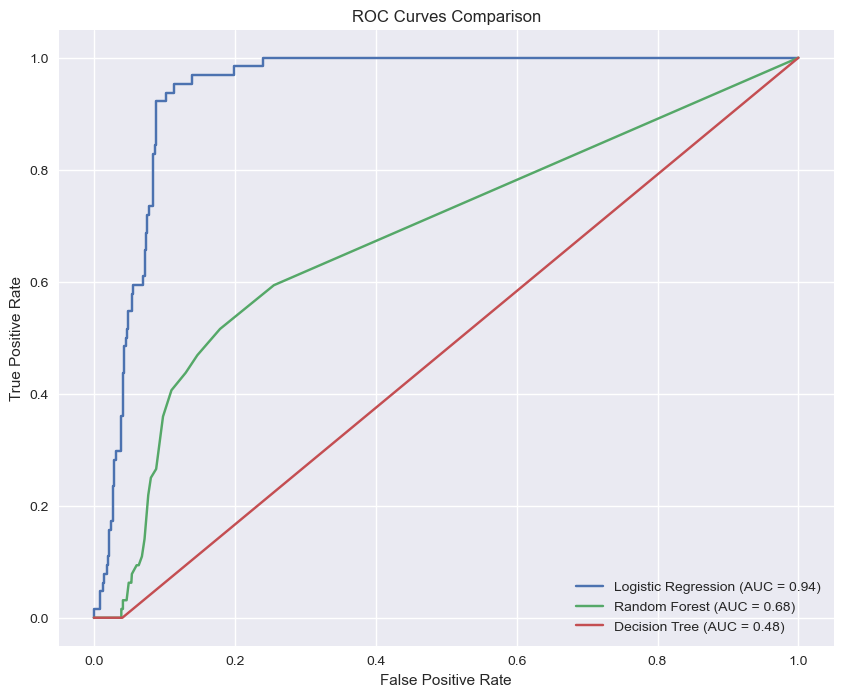

                 Model  Accuracy  F1 Score    Recall  Precision       AUC  \
0  Logistic Regression  0.205147  0.167697  0.187397   0.166967  0.941667   
1        Random Forest  0.809864  0.737144  0.738390   0.739161  0.681355   
2        Decision Tree  0.853467  0.775302  0.775832   0.776744  0.479775   

   Balanced Accuracy  
0           0.187397  
1           0.738390  
2           0.775832  


In [8]:
# Fit models
model_lr = LogisticRegression().fit(X_train_scaled, y_train)
model_rf = RandomForestClassifier().fit(X_train_scaled, y_train)
model_dt = DecisionTreeClassifier().fit(X_train_scaled, y_train)

models = [model_lr, model_rf, model_dt]
model_names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

# Initialize dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Recall': [],
    'Precision': [],
    'AUC': [],
    'Balanced Accuracy':[]
}

# Plot ROC Curves
plt.figure(figsize=(10, 8))

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for the positive class

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc)
    metrics['F1 Score'].append(f1)
    metrics['Recall'].append(rec)
    metrics['Precision'].append(prec)
    metrics['AUC'].append(roc_auc)
    metrics['Balanced Accuracy'].append(balanced_acc)

    # ROC Curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca())

plt.title('ROC Curves Comparison')
plt.show()

# Create DataFrame from metrics dictionary
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


#### Performance Metrics Before HyperParameter Tuning 

In [9]:
df_metrics = pd.DataFrame(metrics)

# Use the style feature to make the table more visually appealing
styled_table = df_metrics.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-family', 'Arial'), ('background-color', '#f4f4f9')]},
     {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-family', 'Arial')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#ffff99')]}]
).set_properties(**{'background-color': '#f9f9f9', 'color': 'black'}).hide_index()

# Display the styled table
styled_table


Model,Accuracy,F1 Score,Recall,Precision,AUC,Balanced Accuracy
Logistic Regression,0.205147,0.167697,0.187397,0.166967,0.941667,0.187397
Random Forest,0.809864,0.737144,0.738390,0.739161,0.681355,0.738390
Decision Tree,0.853467,0.775302,0.775832,0.776744,0.479775,0.775832


In [10]:
# Get probability predictions for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Combine probabilities with actual labels for sorting
data_with_probs = pd.DataFrame({'probabilities': y_probs, 'actual': y_test})

# Sort by probabilities in descending order
data_sorted = data_with_probs.sort_values(by='probabilities', ascending=False)

# Identify the top 10%
top_10_percent_index = int(len(data_sorted) * 0.1)
top_10_percent = data_sorted.head(top_10_percent_index)

# Calculate the number of positives in the top 10%
top_10_positives = top_10_percent['actual'].sum()

# Calculate the baseline positive rate
baseline_rate = data_with_probs['actual'].mean()

# Calculate LIFT
lift = (top_10_positives / top_10_percent_index) / baseline_rate

print(f"LIFT for the top 10%: {lift:.2f}")


LIFT for the top 10%: 1.00


/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Lift Output
LIFT for the top 10%: 1.00

## Hyperparameter Tuning

In [11]:
# Hyperparameter grids
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Types of norm used in the penalization
    'solver': ['liblinear']  # Algorithm to use in the optimization problem
}

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10]  # Minimum number of data points placed in a node before the node is split
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


In [12]:
# Set up GridSearchCV for each model
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=cv, scoring='accuracy', verbose=1)
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=cv, scoring='accuracy', verbose=1)
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=cv, scoring='accuracy', verbose=1)


In [13]:
# Fit the grid search to the data
grid_search_lr.fit(X_train_scaled, y_train)
grid_search_rf.fit(X_train_scaled, y_train)
grid_search_dt.fit(X_train_scaled, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 10 folds for each of 48 candidates, totalling 480 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [14]:
print('Best parameters for Logistic Regression:', grid_search_lr.best_params_)
print('Best score for Logistic Regression:', grid_search_lr.best_score_)

print('Best parameters for Random Forest:', grid_search_rf.best_params_)
print('Best score for Random Forest:', grid_search_rf.best_score_)

print('Best parameters for Decision Tree:', grid_search_dt.best_params_)
print('Best score for Decision Tree:', grid_search_dt.best_score_)


Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.20425057500638893
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best score for Random Forest: 0.8134343853820598
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score for Decision Tree: 0.8479232685918733


In [15]:
best_model_lr = grid_search_lr.best_estimator_
best_model_rf = grid_search_rf.best_estimator_
best_model_dt = grid_search_dt.best_estimator_

In [16]:
from sklearn.metrics import classification_report
import pandas as pd

# Predictions on the test set
y_pred_lr = best_model_lr.predict(X_test_scaled)
y_pred_rf = best_model_rf.predict(X_test_scaled)
y_pred_dt = best_model_dt.predict(X_test_scaled)

# Generate classification reports as dictionaries
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Create a DataFrame with metrics for each model
df_metrics = pd.DataFrame({
    'Logistic Regression': {
        'precision': report_lr['weighted avg']['precision'],
        'recall': report_lr['weighted avg']['recall'],
        'f1-score': report_lr['weighted avg']['f1-score'],
        'accuracy': report_lr['accuracy']
    },
    'Random Forest': {
        'precision': report_rf['weighted avg']['precision'],
        'recall': report_rf['weighted avg']['recall'],
        'f1-score': report_rf['weighted avg']['f1-score'],
        'accuracy': report_rf['accuracy']
    },
    'Decision Tree': {
        'precision': report_dt['weighted avg']['precision'],
        'recall': report_dt['weighted avg']['recall'],
        'f1-score': report_dt['weighted avg']['f1-score'],
        'accuracy': report_dt['accuracy']
    }
})

# Transpose the DataFrame to have models as rows
df_metrics = df_metrics.transpose()

# Print the DataFrame
print(df_metrics)

                     precision    recall  f1-score  accuracy
Logistic Regression   0.195955  0.211580  0.189905  0.211580
Random Forest         0.837576  0.827734  0.830022  0.827734
Decision Tree         0.851384  0.855611  0.853084  0.855611


/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, balanced_accuracy_score
import pandas as pd

# Assuming you have already trained your models and have the predictions: y_pred_lr, y_pred_rf, y_pred_dt

# Create a dictionary to hold your metrics
metrics2_dict = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dt)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted')
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_dt, average='weighted')
    ],
    'Balanced Accuracy': [
        balanced_accuracy_score(y_test, y_pred_lr),
        balanced_accuracy_score(y_test, y_pred_rf),
        balanced_accuracy_score(y_test, y_pred_dt)
    ]
}

# Convert the dictionary into a DataFrame
metrics_df2 = pd.DataFrame(metrics_dict)

# Set the 'Model' column as the index
metrics_df2.set_index('Model', inplace=True)

# Display the DataFrame
print(metrics_df2)


/Users/ayatarist/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'metrics_dict' is not defined

#### Performance Metrics After HyperParameter Tuning 

In [ ]:
df_metric2s = pd.DataFrame(metrics2_dict)

# Use the style feature to make the table more visually appealing
styled_table = df_metric2s.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-family', 'Arial'), ('background-color', '#f4f4f9')]},
     {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-family', 'Arial')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#ffff99')]}]
).set_properties(**{'background-color': '#f9f9f9', 'color': 'black'}).hide_index()

# Display the styled table
styled_table